In [2]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, KFold
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import os
import cv2
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import math
from scipy.stats import pearsonr  # Import Pearson correlation function


In [5]:

# Define the transformations for the dataset
common_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# a function to resize the images to 224 regardless of their lenght and width.
def resize_and_pad_white(image, target_size=(224, 224)):
    # Convert the NumPy array image to a PIL Image
    pil_image = Image.fromarray(image)

    # Calculate the aspect ratio of the original image
    width, height = pil_image.size
    aspect_ratio = width / height

    # Calculate the target aspect ratio
    target_width, target_height = target_size
    target_aspect_ratio = target_width / target_height

    if aspect_ratio > target_aspect_ratio:
        # Original image is wider, fix the width to match the target width
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Original image is taller, fix the height to match the target height
        new_width = int(target_height * aspect_ratio)
        new_height = target_height

    # Resize the image to the calculated size
    resized_image = pil_image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a new blank image with the target size and white background
    padded_image = Image.new('RGB', target_size, (255, 255, 255))

    # Calculate the position to center the resized image
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2

    # Paste the resized image onto the blank image
    padded_image.paste(resized_image, (left, top))

    return np.array(padded_image)




In [6]:
# Define the custom image dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.images = []
        self.img_dir = img_dir
        self.transform = transform
        self.classes = set()
        self.class_counts = {}
        for img in os.listdir(img_dir):
            imgSplit = img.split('-')
            weight = float(imgSplit[2])

            self.images.append([img, weight])

            self.labels = [sample[1] for sample in self.images]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx][0])
        if os.path.exists(img_path):
            image = cv2.imread(img_path)
            original_size = image.shape[:2]
            image = resize_and_pad_white(image, target_size=(224, 224))
            image = np.asarray(image)
            if self.transform:
                image = self.transform(image)
            labels = self.images[idx][1]  # Weight
            original_size = torch.tensor(original_size, dtype=torch.float32)
            return image, labels, original_size

# Define the transformation
common_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [9]:
# Initialize your dataset
img_path = "/content/drive/MyDrive/BSF_Phenotyping_pipelines/LarvaNew"
dataset = CustomImageDataset(img_path, transform=common_transform)

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
validation_dataset = torch.utils.data.Subset(dataset, val_indices)


In [10]:
# Define a function to extract features and concatenate the original sizes
def extract_features(dataset, model):
    model.eval()
    features = []
    labels = []
    original_sizes = []

    for idx in range(len(dataset)):
        image, label, original_size = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            features.append(output)
            original_sizes.append(original_size)
            labels.append(label)

    features = torch.cat(features).view(len(dataset), -1)
    original_sizes = torch.stack(original_sizes)
    labels = torch.tensor(labels)

    # Concatenate the features with original sizes
    combined_input = torch.cat((features, original_sizes), dim=1)

    return combined_input, labels

# Load a pre-trained ResNet model
model = models.resnet101(weights='IMAGENET1K_V2')

# Remove the fully connected layer
model = nn.Sequential(*list(model.children())[:-1])

# Extract features from the training data
train_features, train_labels = extract_features(train_dataset, model)

# Extract features from the validation data
validation_features, validation_labels = extract_features(validation_dataset, model)

svr_params = {'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1.0, 10.0],'epsilon': [0.01, 0.1, 0.2]}
# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(SVR(), svr_params, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Retrieve the best model
best_model = grid_search.best_estimator_
print(f"Best model found: {best_model}")

# Retrain the best model on the entire dataset
best_model.fit(train_features, train_labels)
# Evaluate on the test set
y_test_pred = best_model.predict(validation_features)

# Compute final performance metrics
final_rmse = math.sqrt(mean_squared_error(validation_labels, y_test_pred))
final_r, _ = pearsonr(validation_labels, y_test_pred)
final_r2 = r2_score(validation_labels, y_test_pred)

print(f"Final RMSE: {final_rmse:.4f}")
print(f"Final Pearson R: {final_r:.4f}")
print(f"Final R²: {final_r2:.4f}")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 99.1MB/s]


Best model found: SVR(epsilon=0.2, kernel='linear')
Final RMSE: 21.1855
Final Pearson R: 0.8411
Final R²: 0.7036


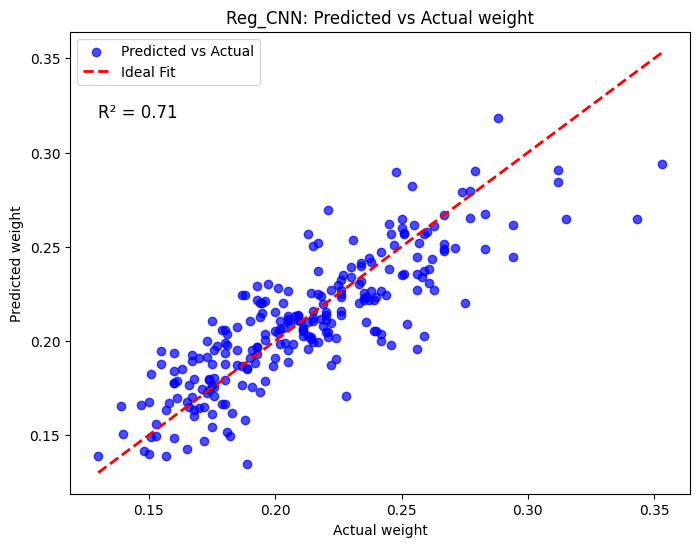

In [11]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(validation_labels*0.001, y_test_pred*0.001, alpha=0.7, color='blue', label="Predicted vs Actual")
plt.plot([min(validation_labels*0.001), max(validation_labels*0.001)], [min(validation_labels*0.001), max(validation_labels*0.001)],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")
plt.xlabel("Actual weight")
plt.ylabel("Predicted weight")
plt.title("Reg_CNN: Predicted vs Actual weight")
plt.legend()
plt.text(min(validation_labels*0.001), max(y_test_pred*0.001), f'R² = {0.71:.2f}', fontsize=12, color='black')

plt.savefig("scatter_plot.png", dpi=300, bbox_inches='tight')

plt.show()